In [1]:
import sys, os
sys.path.append("/home/files/cnsi-sed")

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
import tensorflow.keras.layers as layers
import tensorflow as tf
import numpy as np
import os

from models.layers import create_conf_head_layers, create_loc_head_layers

In [3]:
num_classes = 3

In [4]:
block1 = tf.keras.Sequential([tf.keras.layers.Conv2D(512, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.DepthwiseConv2D(3, strides=(1,1), padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.Conv2D(512, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,20,20,512]

block2 = tf.keras.Sequential([tf.keras.layers.Conv2D(512, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.DepthwiseConv2D(3, strides=(2,2), padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.Conv2D(512, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,10,10,512]
        
block3 = tf.keras.Sequential([tf.keras.layers.Conv2D(512, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.DepthwiseConv2D(3, strides=(2,2), padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.Conv2D(512, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,5,5,512]

block4 = tf.keras.Sequential([tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.DepthwiseConv2D(3, strides=(2,2), padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,3,3,512]
        
block5 = tf.keras.Sequential([tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.DepthwiseConv2D(3),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,1,1,512]

In [5]:
mobilenet_v2 = MobileNetV2(input_shape=(160,160,3), weights="imagenet", include_top=False)

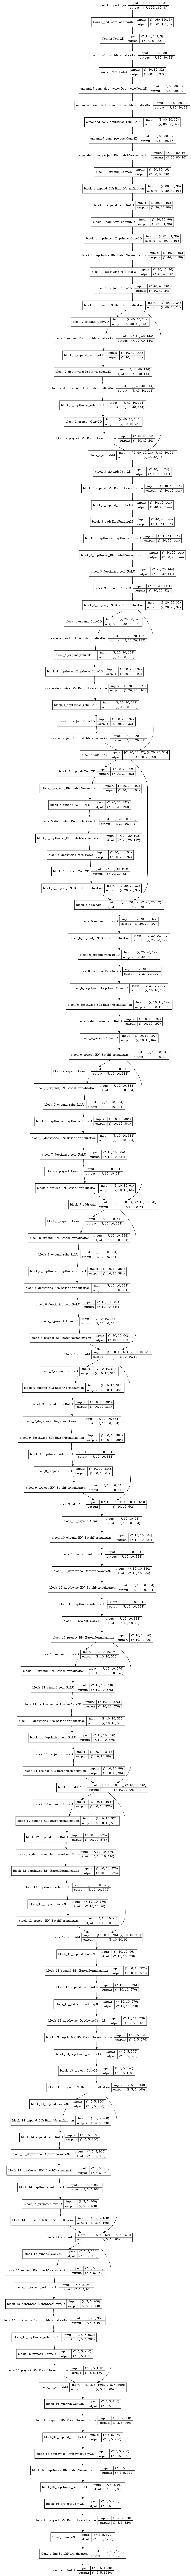

In [6]:
tf.keras.utils.plot_model(mobilenet_v2, show_shapes=True, expand_nested=True)

In [7]:
mobilenet_v2 = MobileNetV2(input_shape=(160,160,3), weights="imagenet", include_top=False)
# feature extractor
fmap20x20 = mobilenet_v2.get_layer("block_6_expand_relu")
feature_extractor = tf.keras.Model(inputs=[mobilenet_v2.input], outputs=[fmap20x20.output])

input_layer = tf.keras.Input(shape=(160,160,3))
x = feature_extractor(input_layer)
y1 = block1(x)
y2 = block2(y1)
y3 = block3(y2)
y4 = block4(y3)
y5 = block5(y4)

In [8]:
print(x.shape)
print(y1.shape)
print(y2.shape)
print(y3.shape)
print(y4.shape)
print(y5.shape)

(None, 20, 20, 192)
(None, 20, 20, 512)
(None, 10, 10, 512)
(None, 5, 5, 512)
(None, 3, 3, 512)
(None, 1, 1, 512)


In [9]:
#conf header
confs = []
conf = layers.Conv2D(8 * num_classes, kernel_size=3, padding='same')(x)
conf = tf.reshape(conf, [-1, 20*20*8,num_classes])
confs.append(conf)
conf = layers.Conv2D(8 * num_classes, kernel_size=3, padding='same')(y1)
conf = tf.reshape(conf, [-1, 20*20*8,num_classes])
confs.append(conf)
conf = layers.Conv2D(8 * num_classes, kernel_size=3, padding='same')(y2)
conf = tf.reshape(conf, [-1, 10*10*8,num_classes])
confs.append(conf)
conf = layers.Conv2D(4 * num_classes, kernel_size=3, padding='same')(y3)
conf = tf.reshape(conf, [-1, 5*5*4,num_classes])
confs.append(conf)
conf = layers.Conv2D(4 * num_classes, kernel_size=3, padding='same')(y4)
conf = tf.reshape(conf, [-1, 3*3*4,num_classes])
confs.append(conf)
conf = layers.Conv2D(4 * num_classes, kernel_size=1)(y5)
conf = tf.reshape(conf, [-1, 1*1*4,num_classes])
confs.append(conf)


#location header
locs = []
loc = layers.Conv2D(8 * 4, kernel_size=3, padding='same')(x)
loc = tf.reshape(loc, [-1, 20*20*8,4])
locs.append(loc)
loc = layers.Conv2D(8 * 4, kernel_size=3, padding='same')(y1)
loc = tf.reshape(loc, [-1, 20*20*8,4])
locs.append(loc)
loc = layers.Conv2D(8 * 4, kernel_size=3, padding='same')(y2)
loc = tf.reshape(loc, [-1, 10*10*8,4])
locs.append(loc)
loc = layers.Conv2D(4 * 4, kernel_size=3, padding='same')(y3)
loc = tf.reshape(loc, [-1, 5*5*4,4])
locs.append(loc)
loc = layers.Conv2D(4 * 4, kernel_size=3, padding='same')(y4)
loc = tf.reshape(loc, [-1, 3*3*4,4])
locs.append(loc)
loc = layers.Conv2D(4 * 4, kernel_size=1)(y5)
loc = tf.reshape(loc, [-1, 1*1*4,4])
locs.append(loc)

confs = tf.concat(confs, axis=-2)
locs = tf.concat(locs, axis=-2)

In [10]:
mobilenet_ssd = tf.keras.Model(inputs=[input_layer], outputs=[confs,locs])

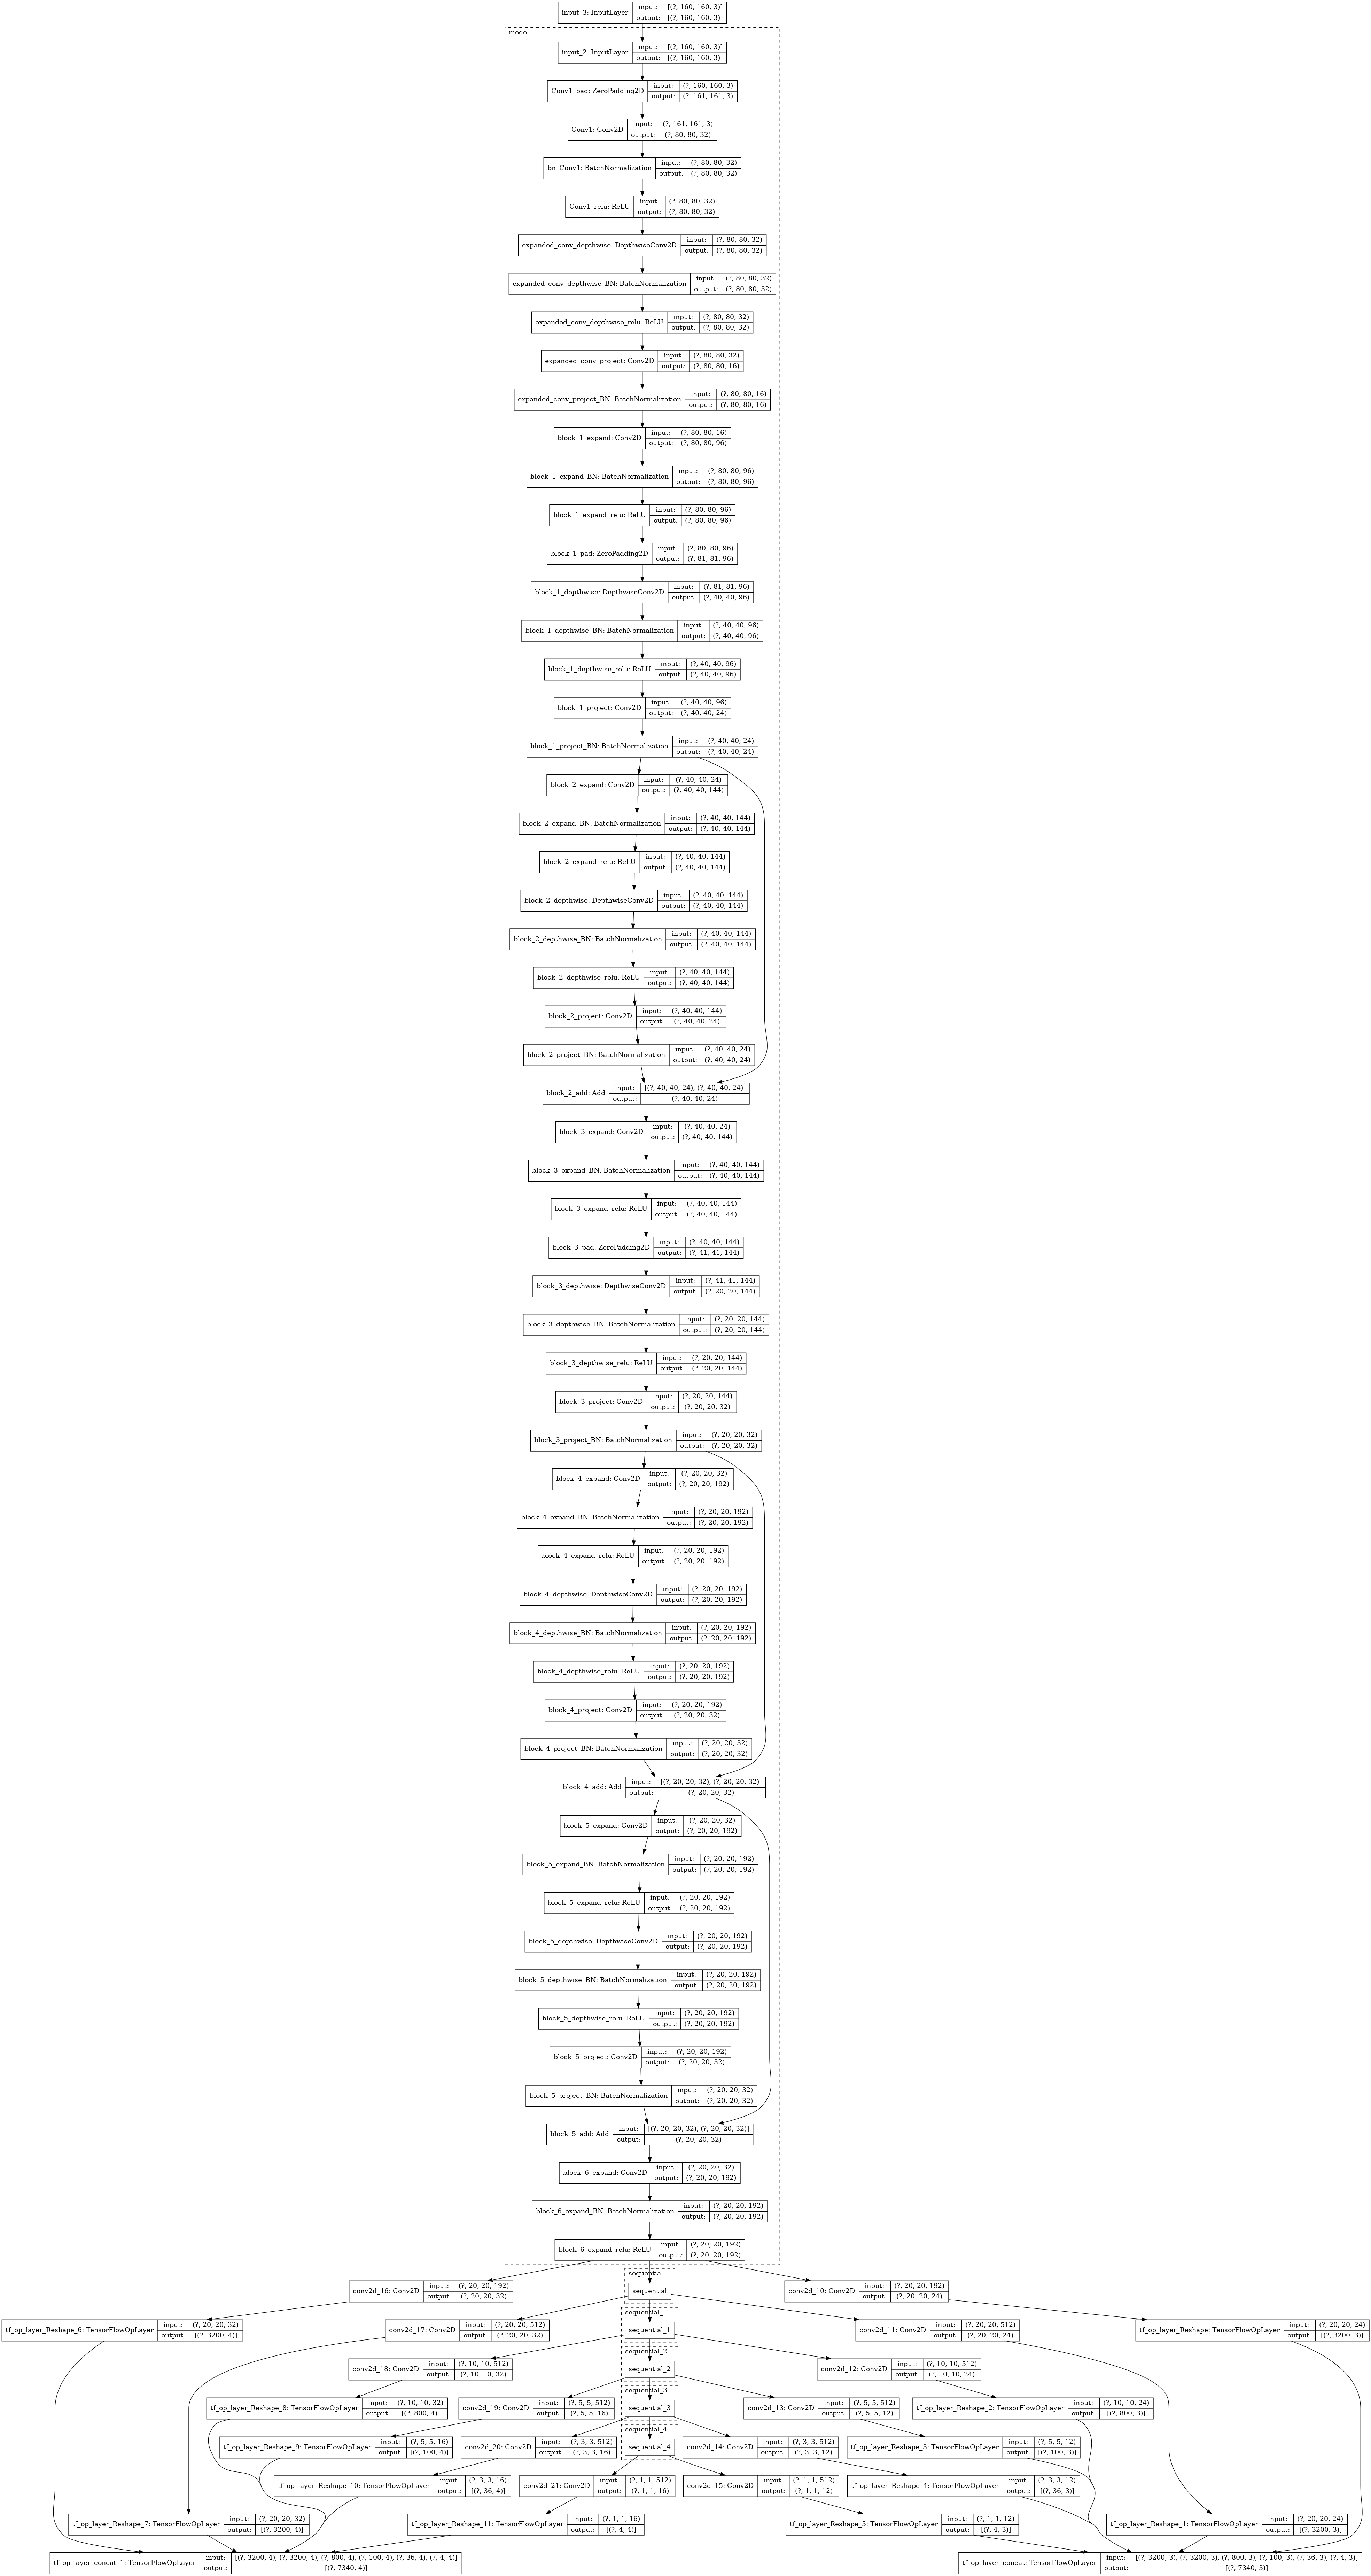

In [11]:
tf.keras.utils.plot_model(mobilenet_ssd, show_shapes=True, expand_nested=True)

In [ ]:
mobilenet_ssd.summary()

In [ ]:
mobilenet_ssd.layers

In [ ]:
mobilenet_ssd.save("ssd-mobile-160-small_ojb2-c3")